In [ ]:
# Based on https://neuro.cs.ut.ee/what-neural-networks-actually-do/

In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import logging
import inspect

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

from keras.models import Model
from keras.layers import Dense, Input

import keras.backend as K
import tensorflow as tf

In [ ]:
class Activation(keras.layers.Layer):
  def __init__(self, activation_functions=[keras.activations.relu, keras.activations.sigmoid, K.cos], enable_debug=False):
    super(Activation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)
    self.enable_debug = enable_debug

  def get_config(self):
    base_config = super(Activation, self).get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.units,),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    debug(tensor_outputs)
    softmax_weights = self.softmax(self.w)
    debug(softmax_weights)
    index = [slice(None)] + [np.newaxis] * len(inputs.shape)
    debug(index)
    multiplied_by_weights = tensor_outputs * softmax_weights[tuple(index)]
    debug(multiplied_by_weights)
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)

Text(0, 0.5, 'y')

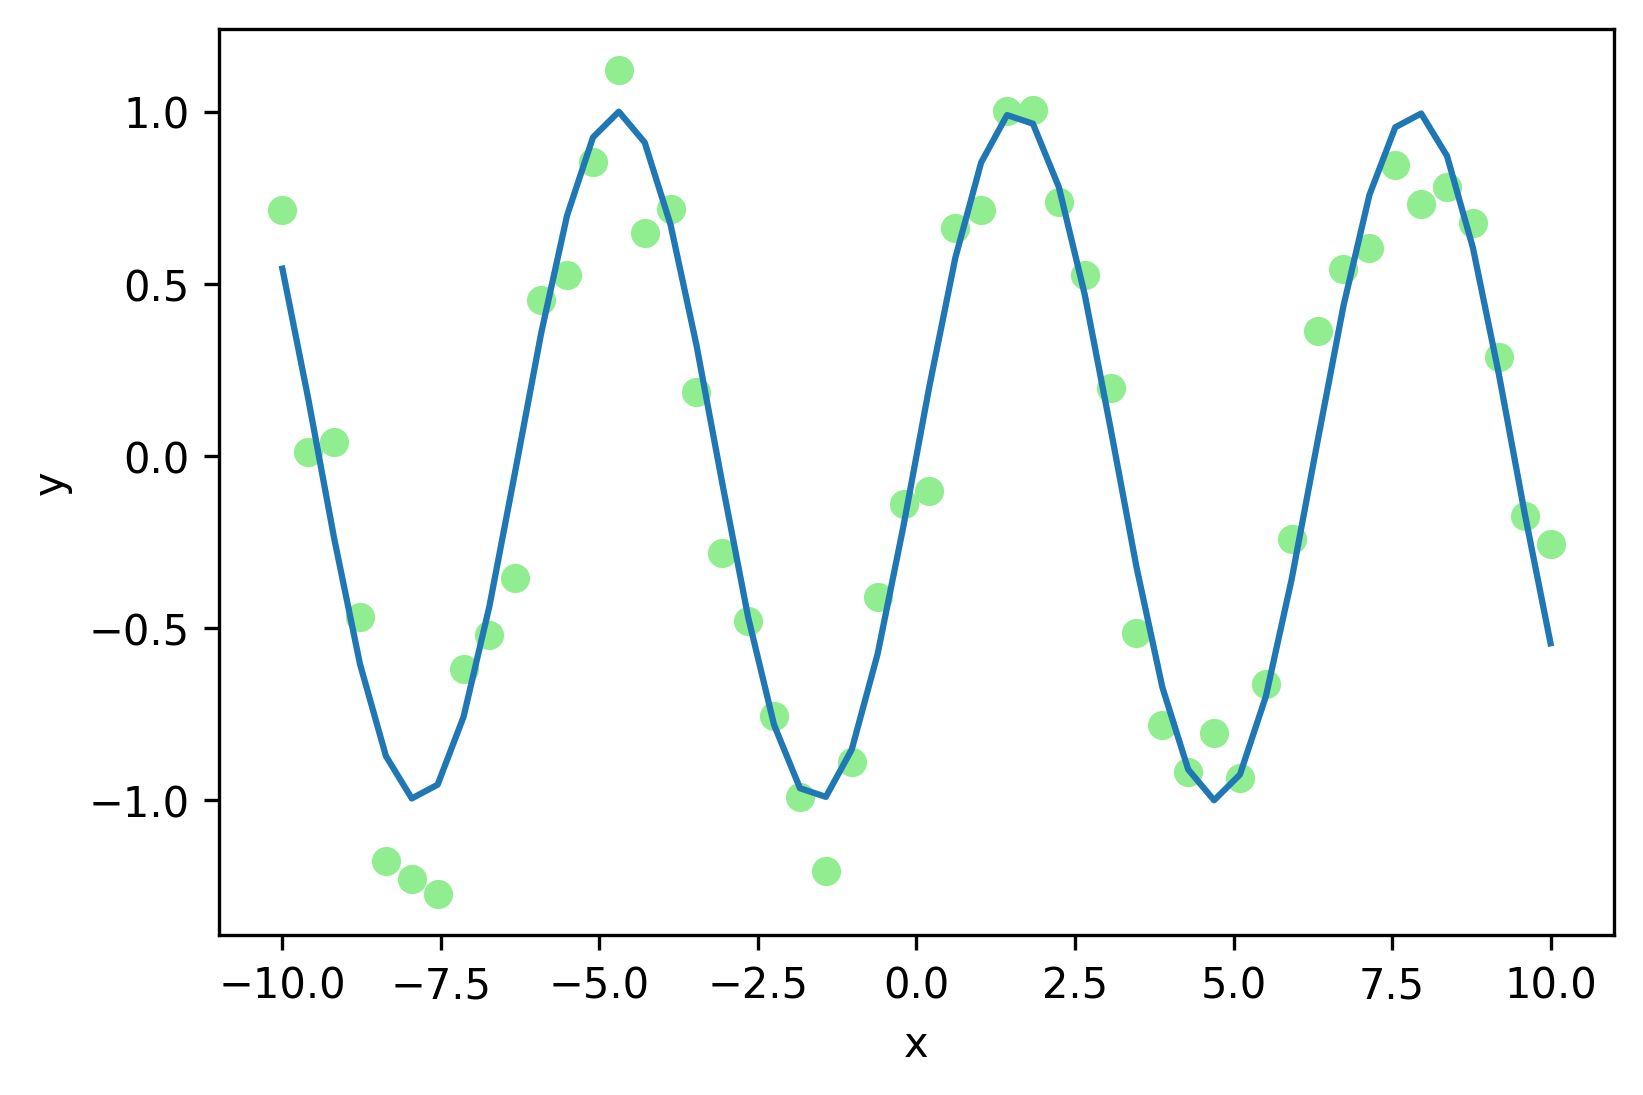

In [ ]:
X = np.linspace(-10, 10, 50)[:,np.newaxis]
y_true = np.sin(X)
noise = np.random.normal(scale=0.15, size=(len(y_true), 1))
y_target = y_true + noise

plt.figure(dpi=300)
plt.plot(X, y_true)
plt.scatter(X, y_target, c='lightgreen')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
x = Input(shape=(1,))
h = Dense(3)(x)
a = Activation(activation_functions=[keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid, K.cos])(h)
y = Dense(1)(a)
model_train = Model(x, y)
model_predict = Model(x, [y, a, h])
model_train.compile(optimizer=keras.optimizers.Adam(0.5), loss='mse')

Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

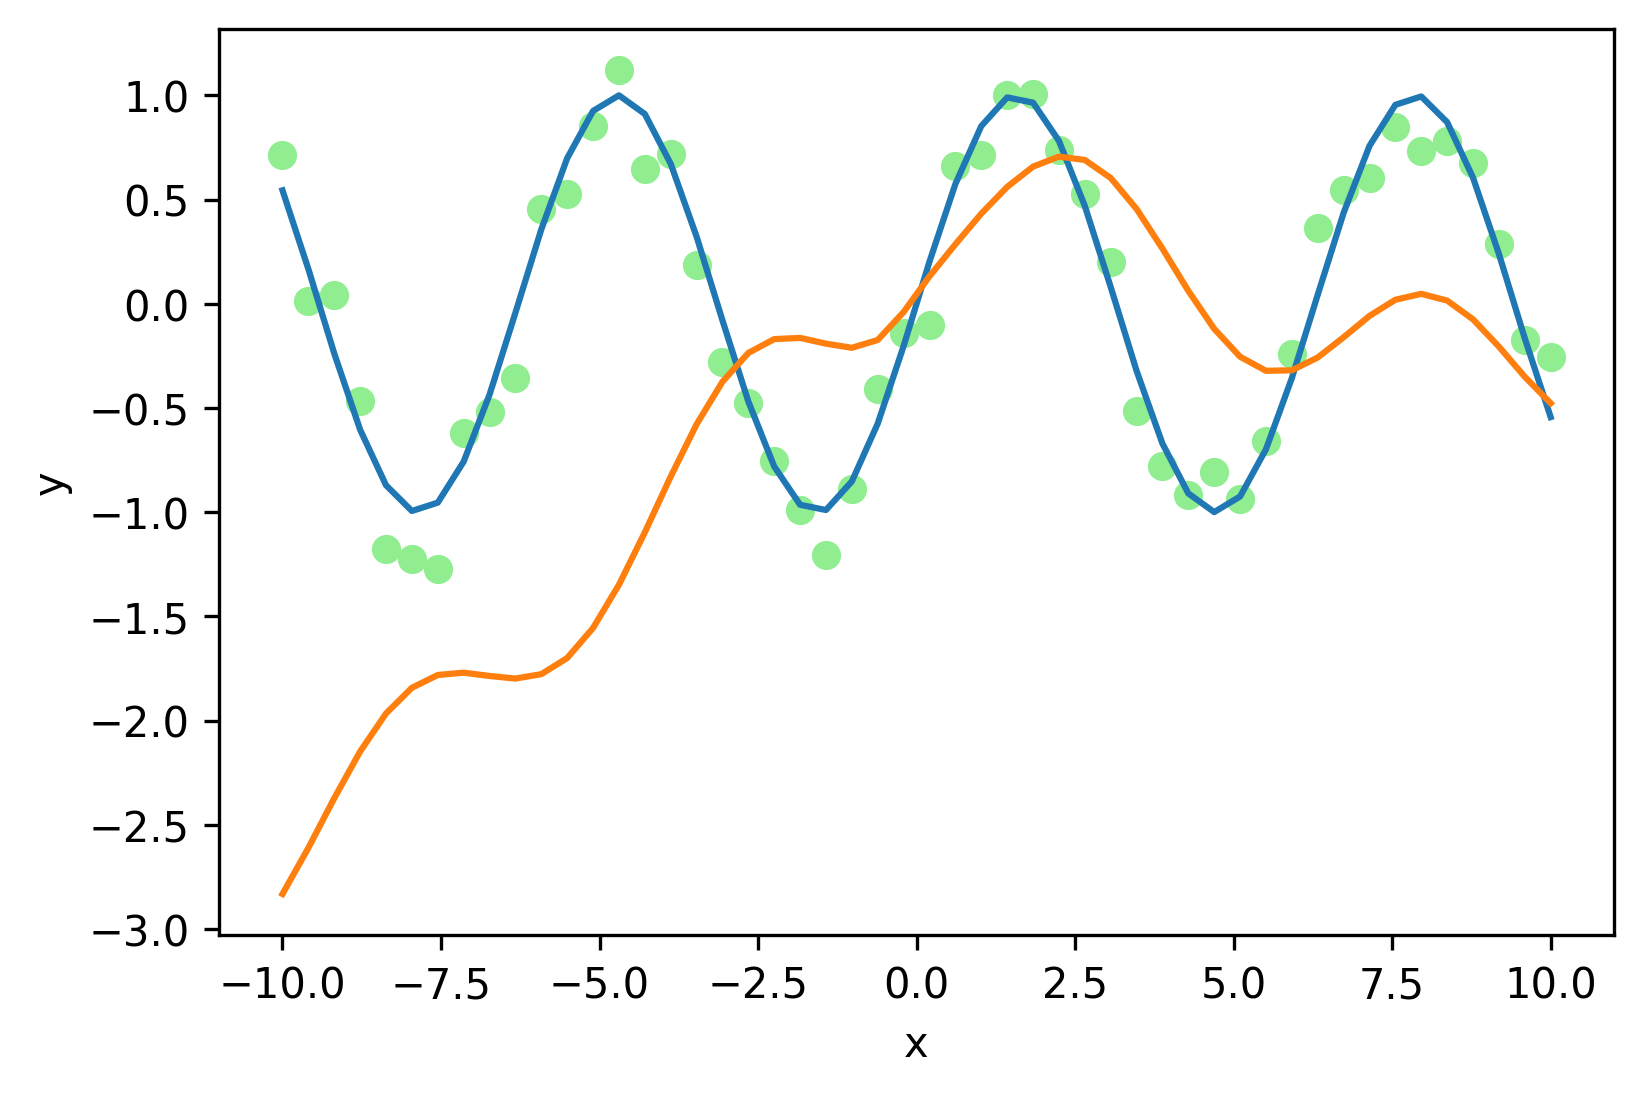

In [ ]:
y_pred = model_train.predict_on_batch(X)
fig = plt.figure()
plt.figure(dpi=300)
plt.plot(X, y_true)
plt.scatter(X, y_target, c='lightgreen')
line, = plt.plot(X, y_pred)
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
def init():
    line.set_data(X, y_pred)
    return (line,)

def animate(i):
    model_train.train_on_batch(X, y_target)
    y_pred = model_train.predict_on_batch(X)
    line.set_data(X, y_pred)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=20, blit=True)
HTML(anim.to_html5_video())

Text(0, 0.5, 'y')

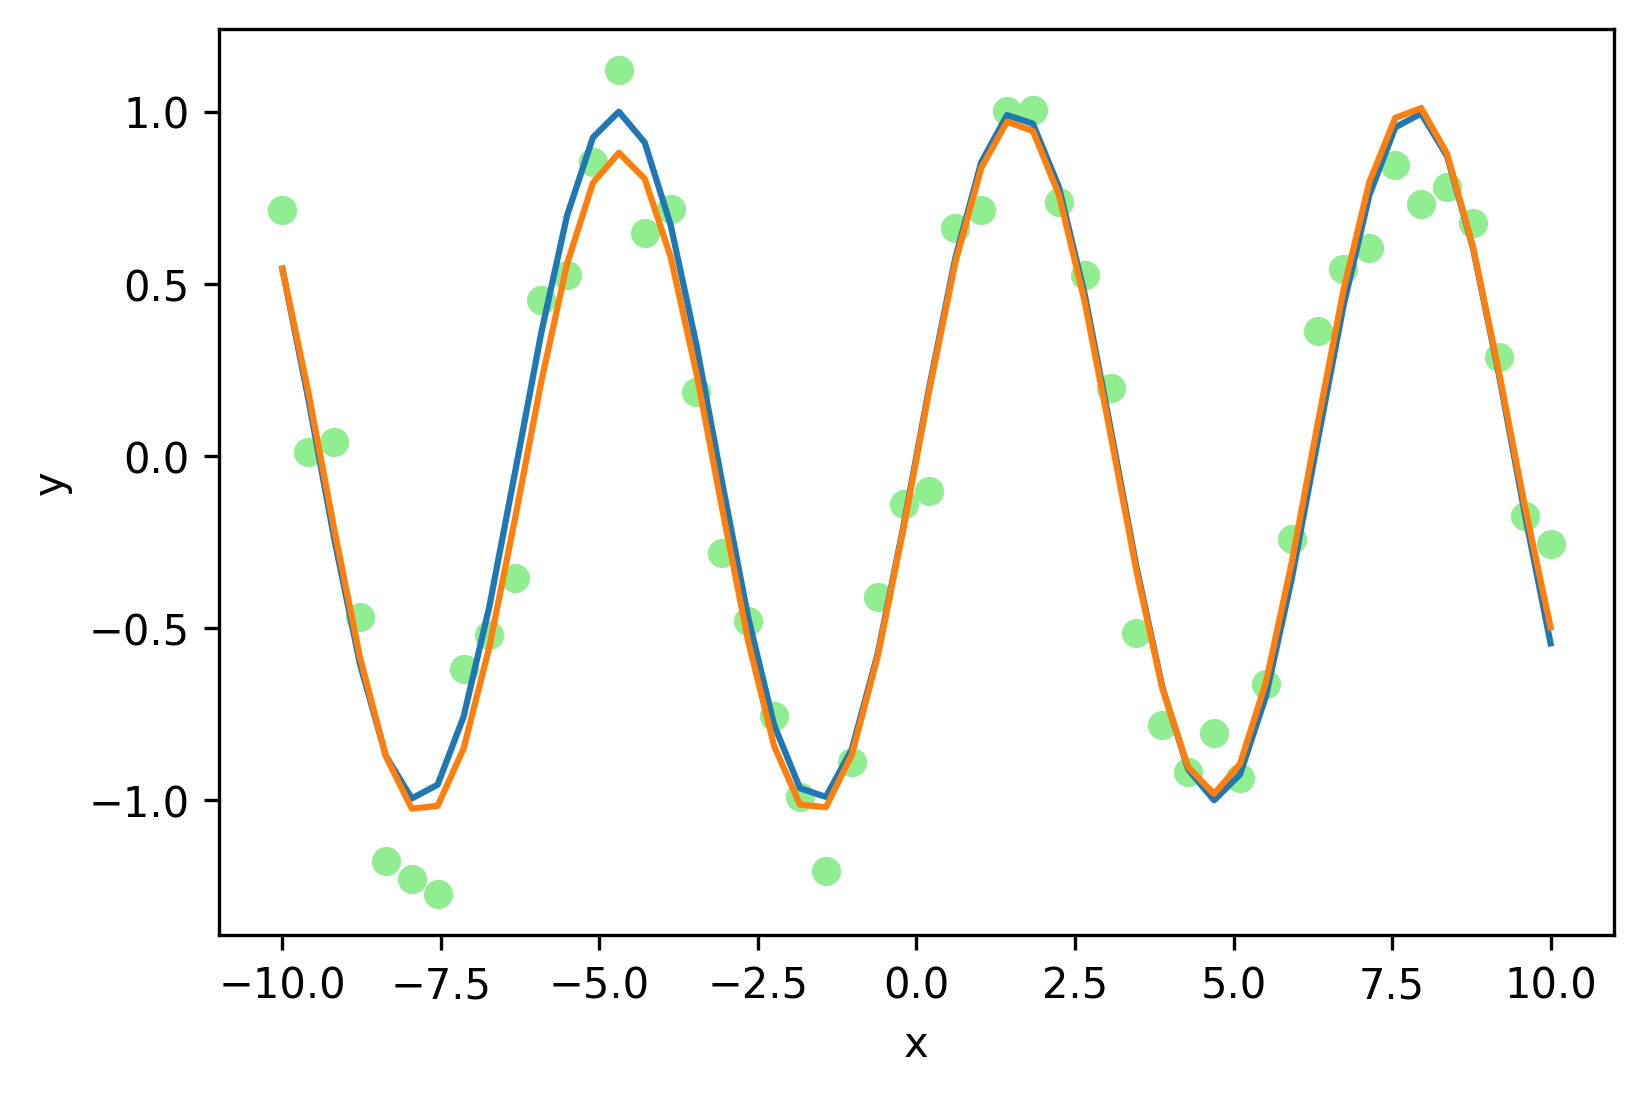

In [ ]:
y_pred, a_pred, h_pred = model_predict.predict_on_batch(X)
W = model_predict.get_weights()
plt.figure(dpi=300)
plt.plot(X, y_true)
plt.scatter(X, y_target, c='lightgreen')
plt.plot(X, y_pred)
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
o1 = model_train.layers[0](X)
o2 = model_train.layers[1](o1)
o3 = model_train.layers[2](o2)
y_pred = model_train.layers[3](o3)

In [ ]:
model_train.get_weights()

[array([[-1.0077133 ,  0.261446  , -0.24122868]], dtype=float32),
 array([-1.5581226 ,  1.9260755 ,  0.90511686], dtype=float32),
 array([-4.646283 ,  2.6744745,  3.1146843,  5.4120855], dtype=float32),
 array([[-1.1410096 ],
        [ 0.01271179],
        [-0.09484274]], dtype=float32),
 array([0.02573619], dtype=float32)]

In [ ]:
W = model_train.get_weights()

<Figure size 432x288 with 0 Axes>

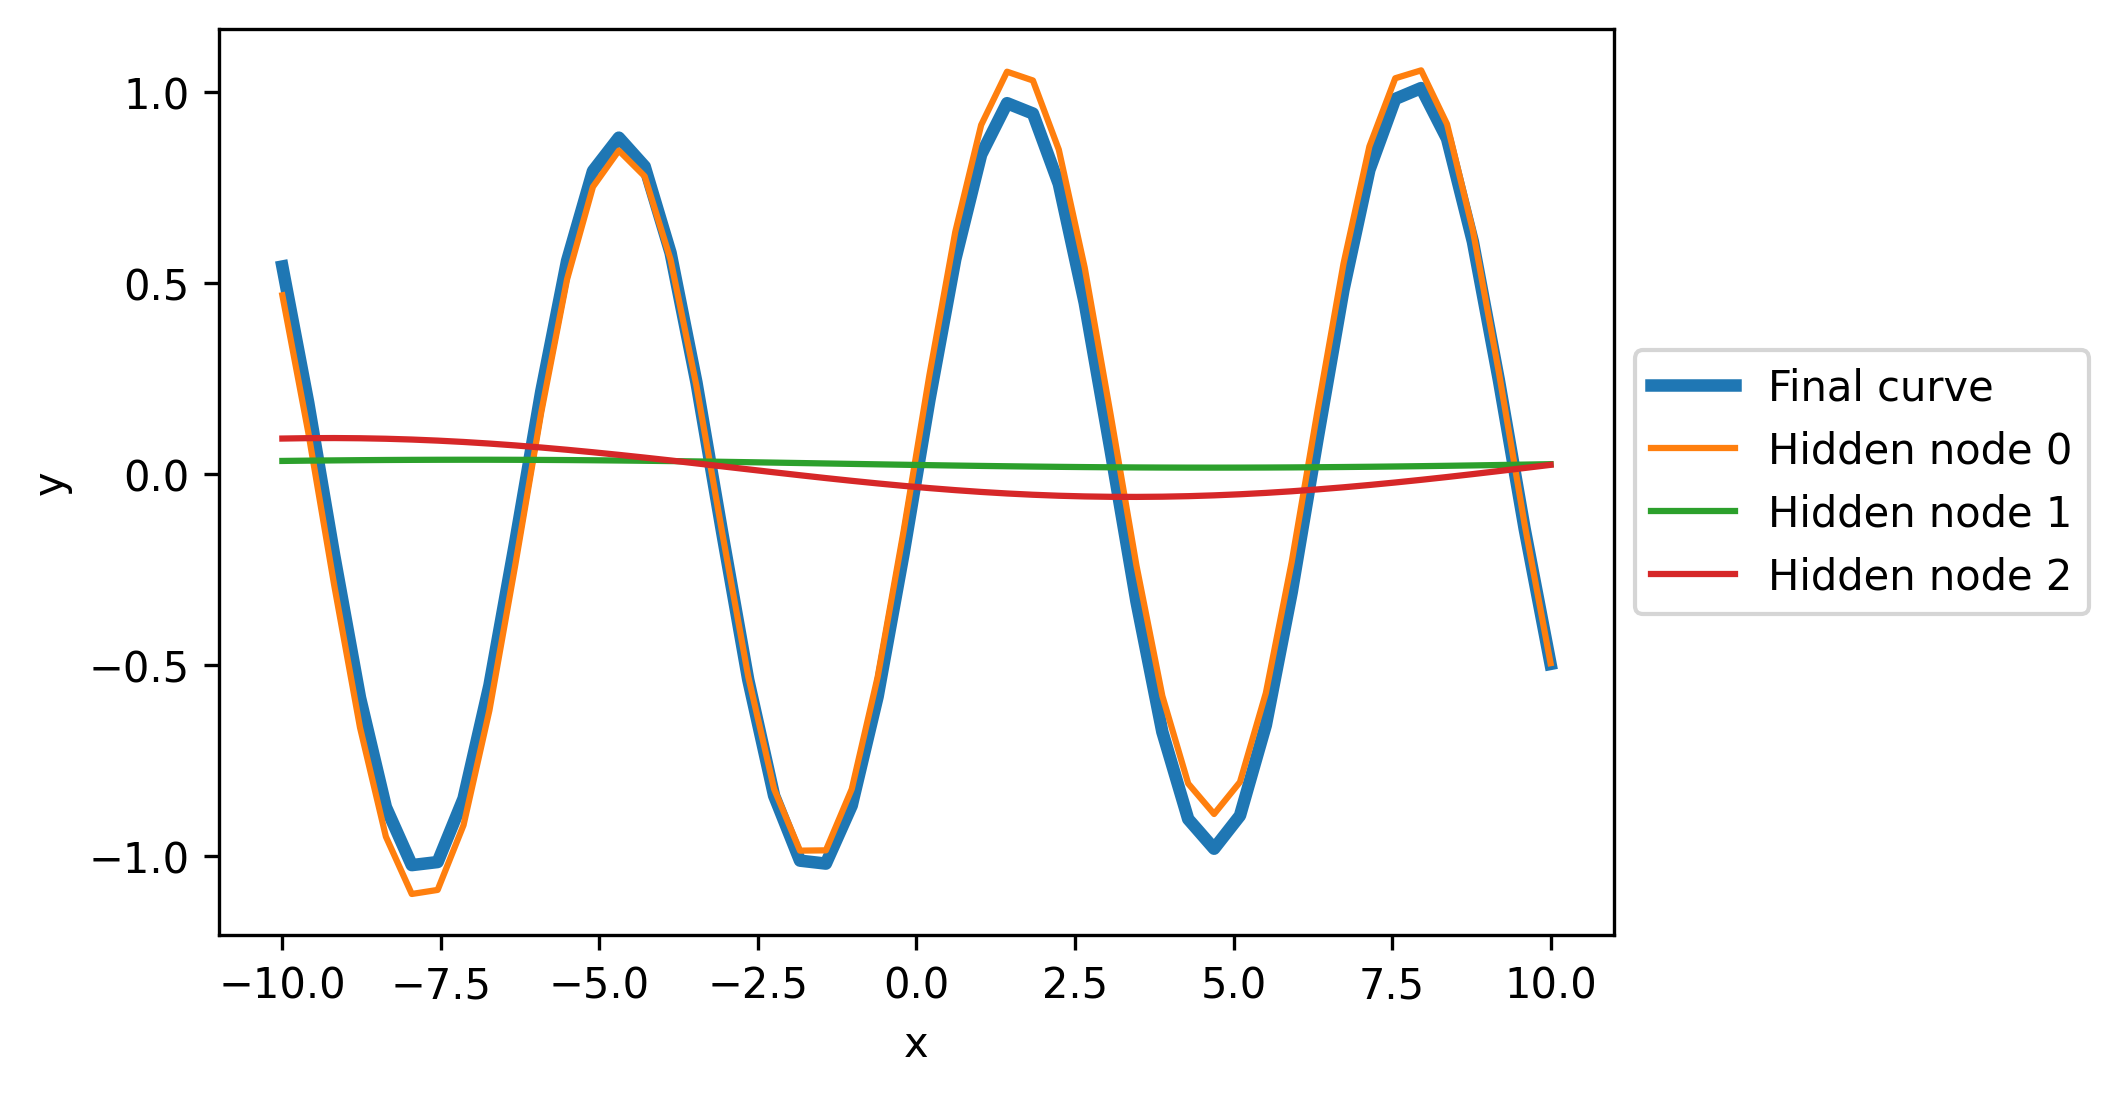

In [ ]:
fig = plt.figure()
plt.figure(dpi=300)
plt.plot(X, y_pred, lw=3)
lines = plt.plot(X, o3 * W[3][:, 0] + W[4])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(["Final curve"] + ["Hidden node %d" % i for i in range(h_pred.shape[1])], loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
def plot_results(model, width=9, height=3):
  for layer in model.layers:
    plt.figure(figsize=(width, height), dpi=300)
    config = layer.get_config()
    if layer.get_config()['name'].split('_')[0] == 'activation':
      weights = keras.activations.softmax(tf.convert_to_tensor(layer.get_weights()))
      # n = math.ceil(math.sqrt(epochs))
      plt.tight_layout()
      labels = list(map(lambda fn: keras.activations.serialize(fn)[:7], layer.activation_functions))
      plt.bar(labels, weights[0])
    plt.show() 

<Figure size 900x900 with 0 Axes>

<Figure size 900x900 with 0 Axes>

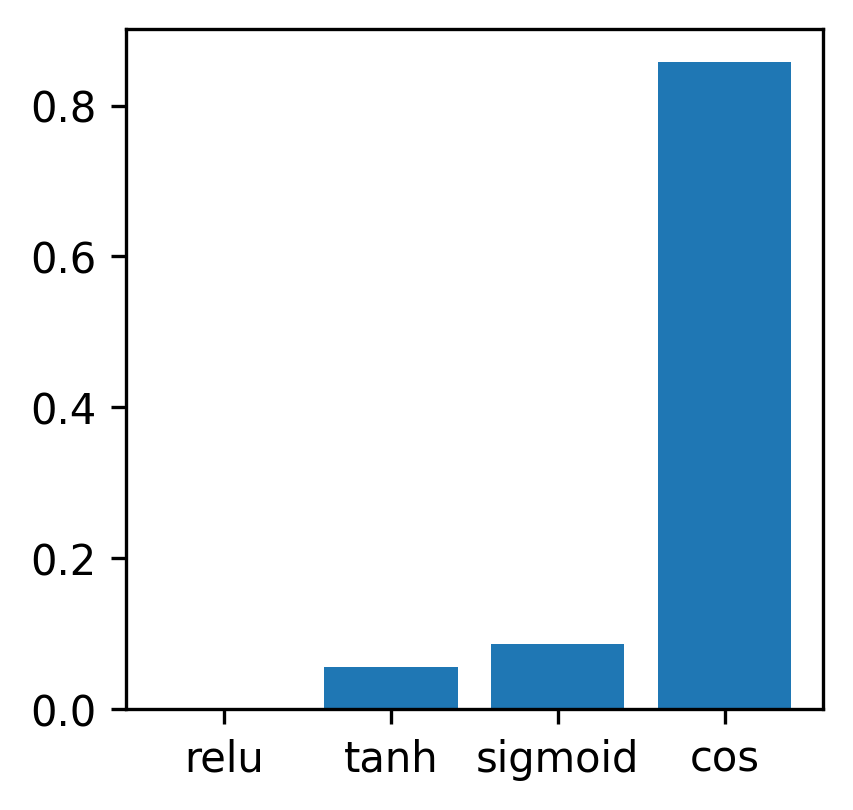

<Figure size 900x900 with 0 Axes>

In [ ]:
plot_results(model_train, width=3, height=3)

Text(0, 0.5, 'y')

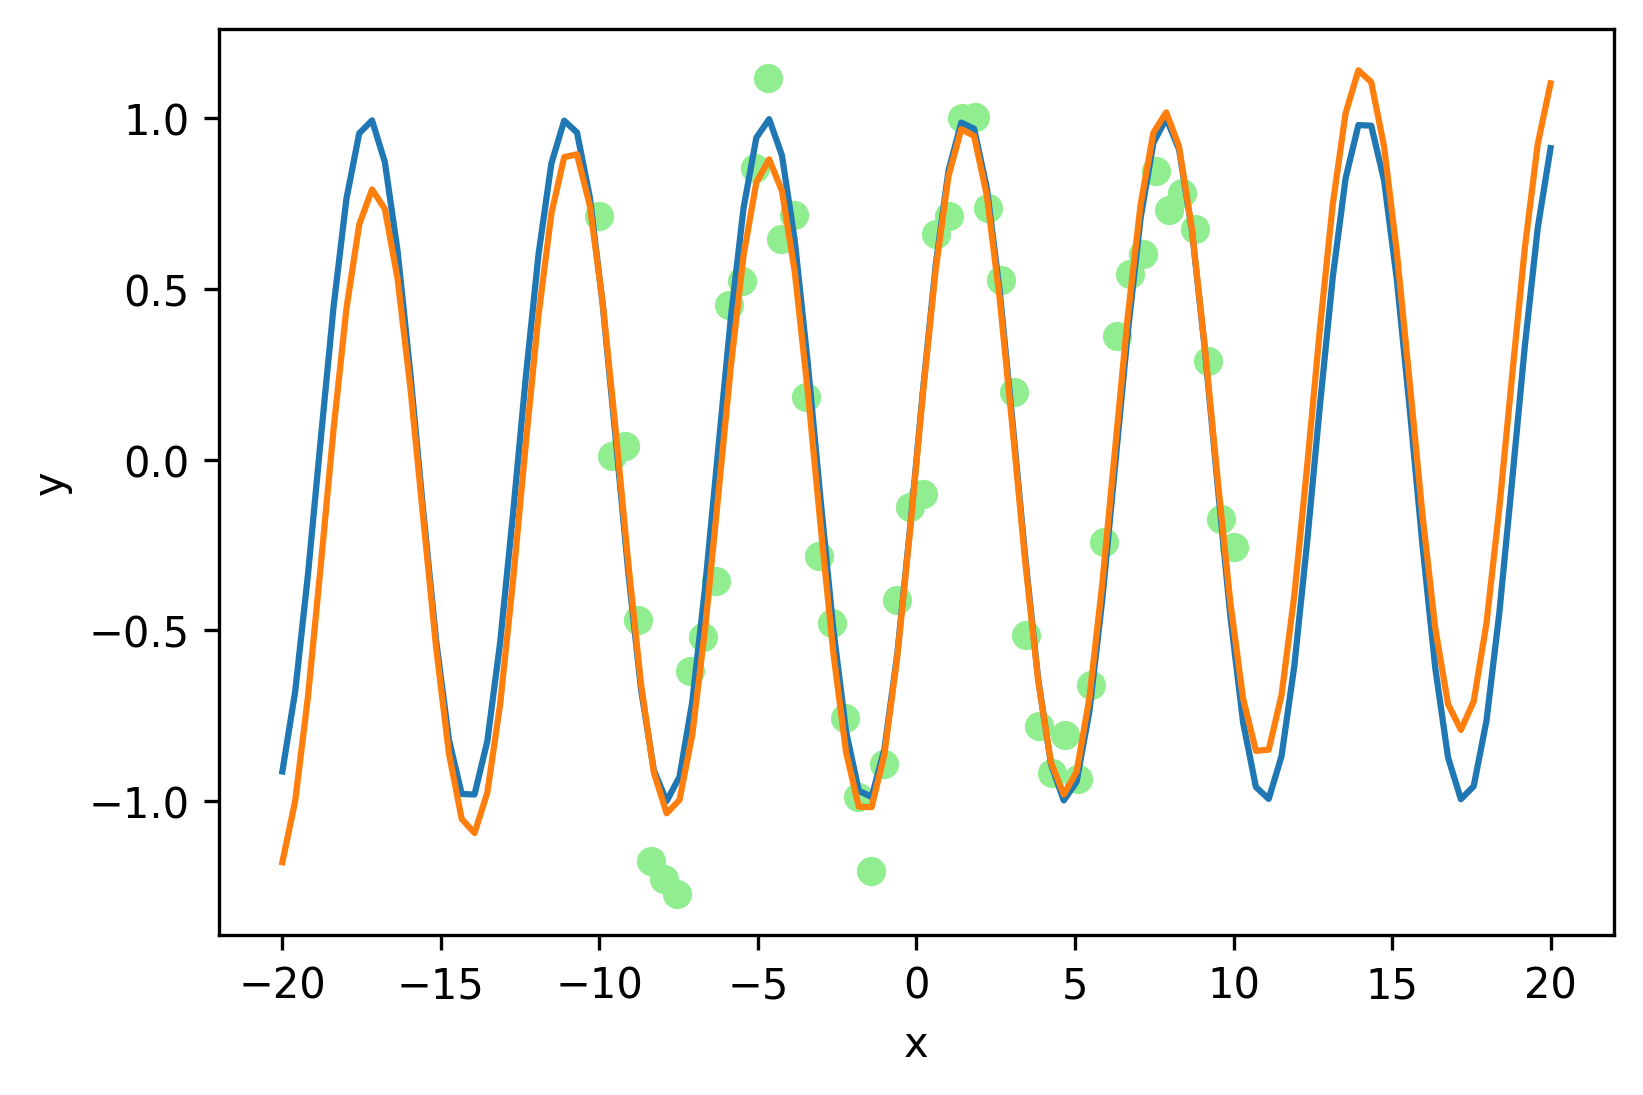

In [ ]:
X_wide = np.linspace(-20, 20, 100)[:,np.newaxis]
y_wide_true = np.sin(X_wide)
y_wide_pred = model_train.predict(X_wide)
plt.figure(dpi=300)
plt.plot(X_wide, y_wide_true)
plt.scatter(X, y_target, c='lightgreen')
plt.plot(X_wide, y_wide_pred)
plt.xlabel('x')
plt.ylabel('y')

# Test 2

In [ ]:
x = Input(shape=(1,))
h = Dense(10)(x)
a = Activation(activation_functions=[keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid, keras.activations.linear])(h)
y = Dense(1)(a)
model_train = Model(x, y)
model_predict = Model(x, [y, a, h])
model_train.compile(optimizer=keras.optimizers.Adam(0.5), loss='mse')

Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

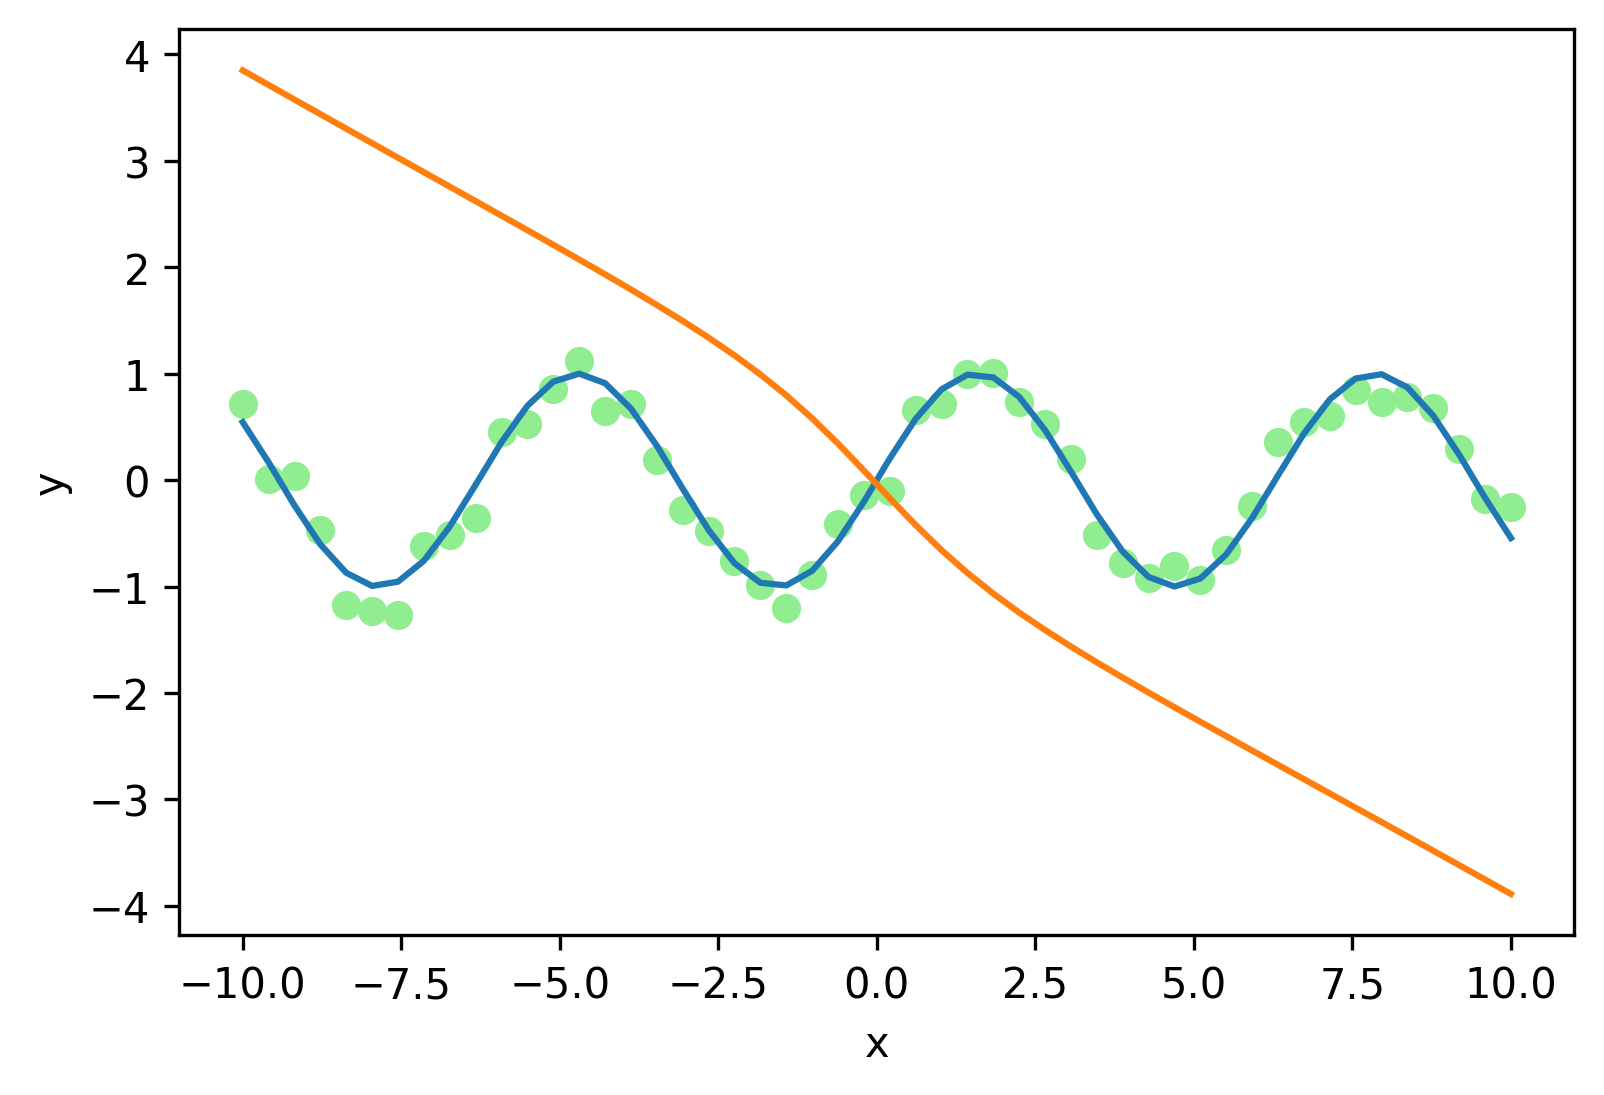

In [ ]:
y_pred = model_train.predict_on_batch(X)
fig = plt.figure()
plt.figure(dpi=300)
plt.plot(X, y_true)
plt.scatter(X, y_target, c='lightgreen')
line, = plt.plot(X, y_pred)
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
for _ in range(1000):
  model_train.train_on_batch(X, y_target)

Text(0, 0.5, 'y')

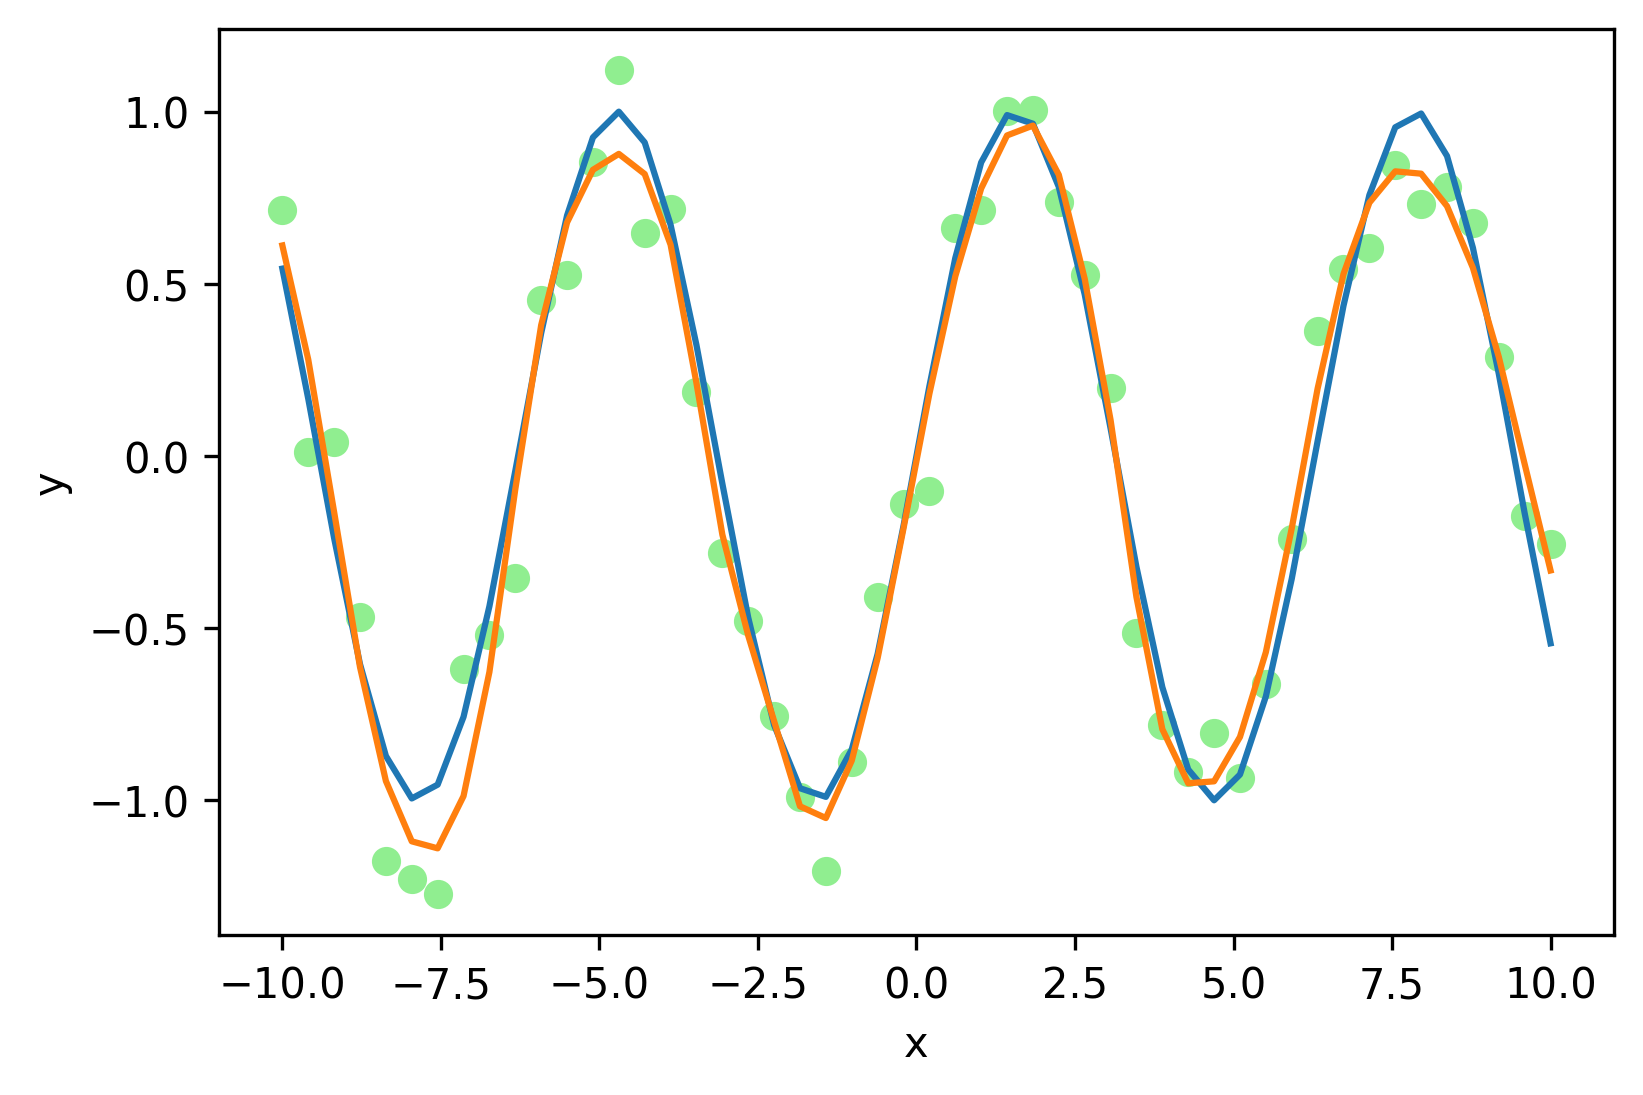

In [ ]:
y_pred, a_pred, h_pred = model_predict.predict_on_batch(X)
W = model_predict.get_weights()
plt.figure(dpi=300)
plt.plot(X, y_true)
plt.scatter(X, y_target, c='lightgreen')
plt.plot(X, y_pred)
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
o1 = model_train.layers[0](X)
o2 = model_train.layers[1](o1)
o3 = model_train.layers[2](o2)
y_pred = model_train.layers[3](o3)

In [ ]:
W = model_train.get_weights()

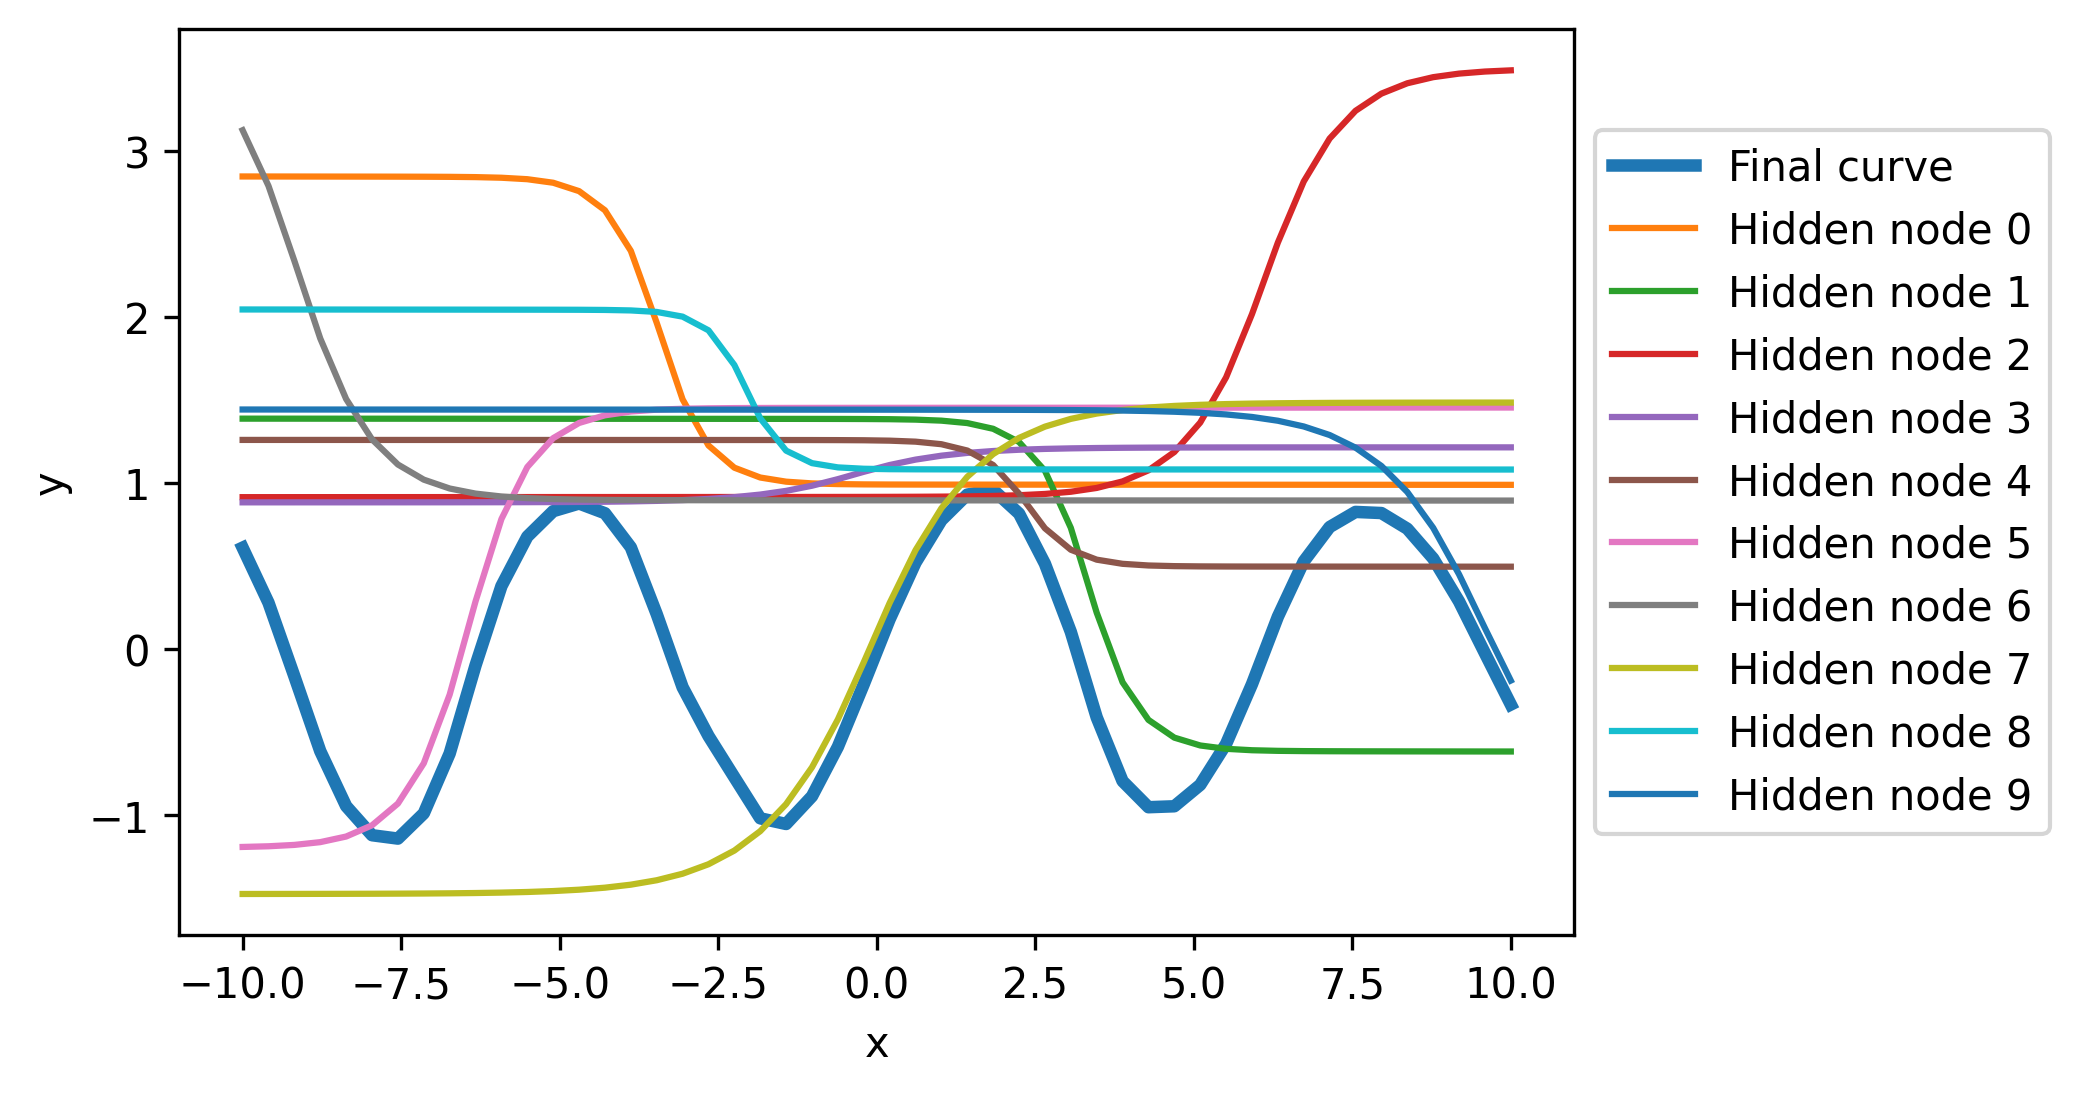

In [ ]:
fig = plt.figure(dpi=300)
plt.plot(X, y_pred, lw=3)
lines = plt.plot(X, o3 * W[3][:, 0] + W[4])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(["Final curve"] + ["Hidden node %d" % i for i in range(h_pred.shape[1])], loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
def plot_results(model, width=10, height=4):
  for layer in model.layers:
    plt.figure(figsize=(width, height), dpi=300)
    config = layer.get_config()
    if layer.get_config()['name'].split('_')[0] == 'activation':
      weights = keras.activations.softmax(tf.convert_to_tensor(layer.get_weights()))
      # n = math.ceil(math.sqrt(epochs))
      plt.tight_layout()
      labels = list(map(lambda fn: keras.activations.serialize(fn)[:7], layer.activation_functions))
      plt.bar(labels, weights[0])
    plt.show() 

<Figure size 900x900 with 0 Axes>

<Figure size 900x900 with 0 Axes>

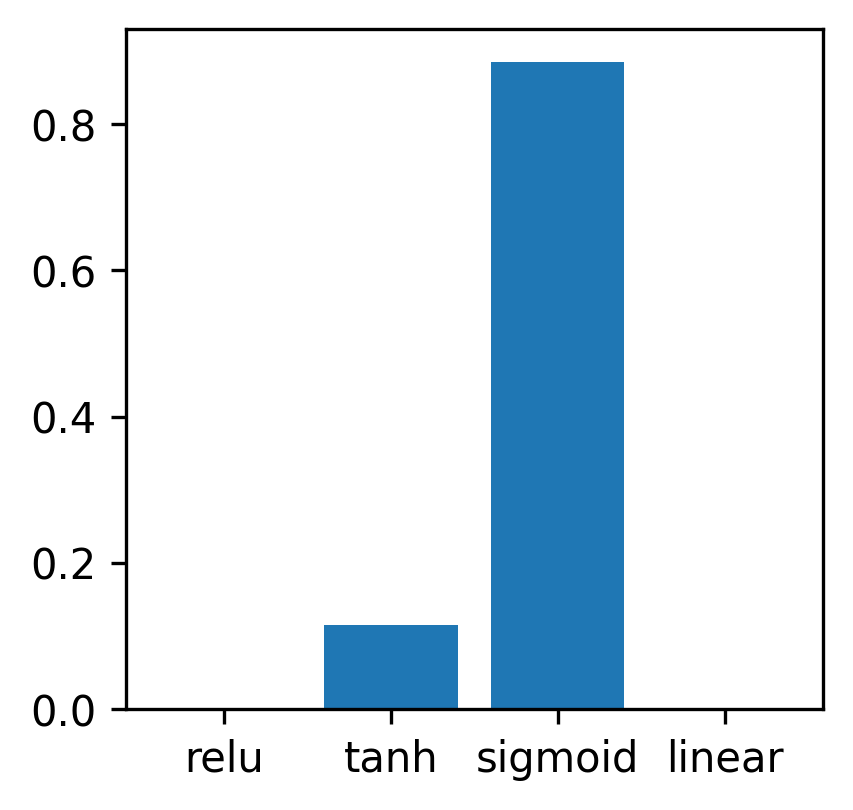

<Figure size 900x900 with 0 Axes>

In [ ]:
plot_results(model_train, width=3, height=3)

Text(0, 0.5, 'y')

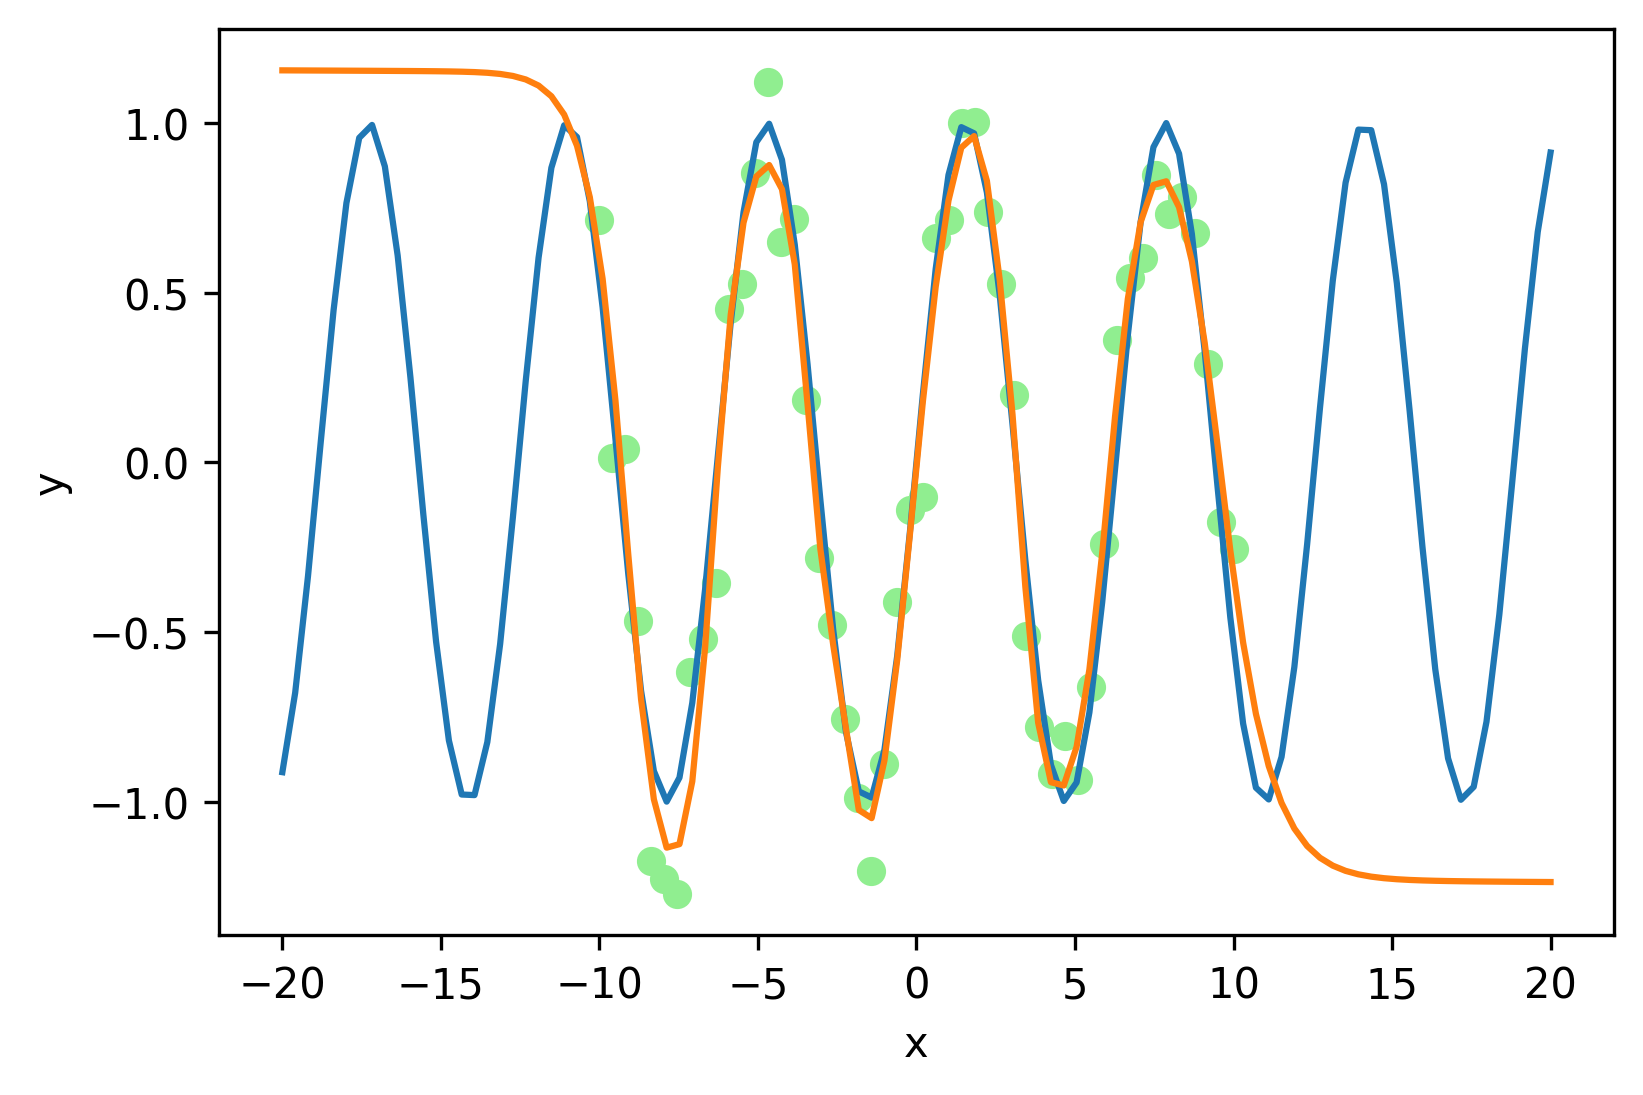

In [ ]:
X_wide = np.linspace(-20, 20, 100)[:,np.newaxis]
y_wide_true = np.sin(X_wide)
y_wide_pred = model_train.predict(X_wide)
plt.figure(dpi=300)
plt.plot(X_wide, y_wide_true)
plt.scatter(X, y_target, c='lightgreen')
plt.plot(X_wide, y_wide_pred)
plt.xlabel('x')
plt.ylabel('y')

# Spirals

In [ ]:
def plot_activation_functions(model, x_start=-5, x_end=5):
  n_activation_layers = len([layer.get_config()['name'].split('_')[0] == 'activation' for layer in model.layers])
  plt.figure(figsize=(5, 10))
  count = 0
  for layer in model.layers:
    if layer.get_config()['name'].split('_')[0] == 'activation':
      count += 1
      x = np.arange(x_start * 10, x_end * 10)/10
      y = layer(tf.convert_to_tensor([x]))
      plt.subplot(n_activation_layers, 1, count)
      plt.tight_layout()
      plt.plot(x, y[0])
      plt.title(layer.get_config()['name'])
  plt.show()

In [ ]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [ ]:
def run_test_3(activation_functions=[keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid, K.cos], n_nodes=3, iterations=100):
  X, y_target = twospirals(1000)
  X_test = np.mgrid[-20:20:0.5, -20:20:0.5].reshape(2,-1).T
  print(X.shape)
  print(X_test.shape)
  # --------------------------------------

  x = Input(shape=(2,))
  h = Dense(n_nodes)(x)
  a = Activation(activation_functions=activation_functions)(h)
  h2 = Dense(n_nodes)(a)
  a2 = Activation(activation_functions=activation_functions)(h2)
  y = Dense(1, activation='sigmoid')(a2)
  model_train = Model(x, y)
  model_train.compile(optimizer='rmsprop', loss='binary_crossentropy')
  
  def plot(X, y, **kwargs):
    y = np.round(y).T[0]
    plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1', **kwargs)
    plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2', **kwargs)


  # --------------------------------------
  
  fig = plt.figure(dpi=300)
  line1, = plt.plot(X[y_target==0,0], X[y_target==0,1], '.', label='class 1')
  line2, = plt.plot(X[y_target==1,0], X[y_target==1,1], '.', label='class 2')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Target function')
  plt.show()

  # --------------------------------------

  y_pred = np.round(model_train.predict_on_batch(X_test)).T[0]
  fig = plt.figure(dpi=300)
  # plotib X kus pred 0 class
  line1, = plt.plot(X_test[y_pred==0,0], X_test[y_pred==0,1], '.', label='class 1', alpha=0.5)
  # plotib X kus pred 1 class
  line2, = plt.plot(X_test[y_pred==1,0], X_test[y_pred==1,1], '.', label='class 2', alpha=0.5)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Predicted function')

  def init():
    line1.set_data(X_test[y_pred==0,0], X_test[y_pred==0,1])
    line2.set_data(X_test[y_pred==1,0], X_test[y_pred==1,1])
    return (line1, line2)

  def animate(i):
    model_train.train_on_batch(X, y_target)
    y_pred = np.round(model_train.predict_on_batch(X_test)).T[0]
    line1.set_data(X_test[y_pred==0,0], X_test[y_pred==0,1])
    line2.set_data(X_test[y_pred==1,0], X_test[y_pred==1,1])
    return (line1, line2)

  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=iterations, interval=20, blit=True)
  display(HTML(anim.to_html5_video()))
  fig.clear()

  plt.figure(dpi=300)
  y_pred_test = model_train.predict_on_batch(X_test)
  plot(X_test, y_pred_test)
  plt.title("Final prediction on test data")
  plt.show()
  plt.figure(dpi=300)
  y_pred_org = model_train.predict_on_batch(X)
  plot(X, y_pred_org)
  plt.title("Final prediction on train data")
  plt.show()

  # --------------------------------------


  o1 = model_train.layers[0](X_test)
  o2 = model_train.layers[1](o1)
  o3 = model_train.layers[2](o2)
  #o4 = model_train.layers[3](o3)
  #o5 = model_train.layers[4](o4)
  #y_pred = model_train.layers[5](o5)
  #
  #w0 = model_train.get_weights()[0]
  #w1 = model_train.get_weights()[1]
  #w2 = model_train.get_weights()[2]
  #w3 = model_train.get_weights()[3]
  w4 = model_train.get_weights()[4]
  #w5 = model_train.get_weights()[5]
  #w6 = model_train.get_weights()[6]
  #
  #print(model_train.summary())
  #
  #print("o1", o1.shape)
  #print("o2", o2.shape)
  #print("o3", o3.shape)
  #print("o4", o4.shape)
  #print("o5", o5.shape)
  #print("y", y_pred.shape)
  #
  #print("w0", np.array(w0).shape)
  #print("w1", np.array(w1).shape)
  #print("w2", np.array(w2).shape)
  #print("w3",  np.array(w3).shape)
  #print("w4", np.array(w4).shape)
  #print("w5", np.array(w5).shape)
  #print("w6", np.array(w6).shape)

  fig = plt.figure(dpi=300)
  yy = np.round(keras.activations.sigmoid(tf.math.reduce_sum(w4.T *  o3, axis=1)))
  print(yy.shape)
  plt.plot(X_test[yy==0,0], X_test[yy==0,1], '.', label='class 1')
  plt.plot(X_test[yy==1,0], X_test[yy==1,1], '.', label='class 2')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Contributions of first hidden layer')
  plt.show()
  
  # --------------------------------------

  plot_results(model_train, width=3, height=3)
  plot_activation_functions(model_train)

  # --------------------------------------

  return model_train


In [ ]:
model_train_spiral = run_test_3(activation_functions=[keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid, K.sin], n_nodes=10, iterations=1500)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model_train_spiral_2 = run_test_3(activation_functions=[keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid, keras.activations.linear], n_nodes=100, iterations=2000)

Output hidden; open in https://colab.research.google.com to view.